In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

# Connect to the database
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Airtel@123",
    database="ecommerce"
)

cur = mydb.cursor()

# List of all unique citites with the customers count located there

In [3]:
query = """select distinct customer_city as city,count(customer_id) as customerCount from customers group by customer_city order by customerCount desc"""
cur.execute(query)
result = cur.fetchall()
df = pd.DataFrame(result, columns=['city', 'customerCount'])
print(df)

                     city  customerCount
0               sao paulo          31080
1          rio de janeiro          13764
2          belo horizonte           5546
3                brasilia           4262
4                curitiba           3042
...                   ...            ...
4114               siriji              2
4115  natividade da serra              2
4116         monte bonito              2
4117           sao rafael              2
4118    eugenio de castro              2

[4119 rows x 2 columns]


# Count the number of Orders placed in 2018

In [4]:
query = """ select count(order_approved_at) as orderCount from orders"""
cur.execute(query)
result = cur.fetchall()
df = pd.DataFrame(result)
print("total orders placed in 2018 are",df[0][0])

total orders placed in 2018 are 198562


# The total Sales per Category.

In [5]:
query = """ select Upper(product_category) as Category,round(sum(payments.payment_value),2) as sales from products join order_items on products.product_id = order_items.product_id join payments on payments.order_id = order_items.order_id group by product_category order by sales desc"""
cur.execute(query)
result = cur.fetchall()
result
df = pd.DataFrame(result, columns=['Category', 'sales'])
print(df)

                       Category       sales
0                BED TABLE BATH  1712553.67
1                 HEALTH BEAUTY  1657373.12
2          COMPUTER ACCESSORIES  1585330.45
3          FURNITURE DECORATION  1430176.39
4               WATCHES PRESENT  1429216.68
..                          ...         ...
69                     PC GAMER     2174.43
70              HOUSE COMFORT 2     1710.54
71               CDS MUSIC DVDS     1199.43
72  FASHION CHILDREN'S CLOTHING      785.67
73       INSURANCE AND SERVICES      324.51

[74 rows x 2 columns]


# The percentage of orders that were paid in installments.

In [6]:
query = """select (sum(case when payment_installments >= 1 then 1 else 0 end)/count(payment_installments))*100 as percentage from payments"""
cur.execute(query)
result = cur.fetchall()
df = pd.DataFrame(result)
print("percentage of orders with installments is",df[0][0])

percentage of orders with installments is 99.9981


# The number of customers from each state. 

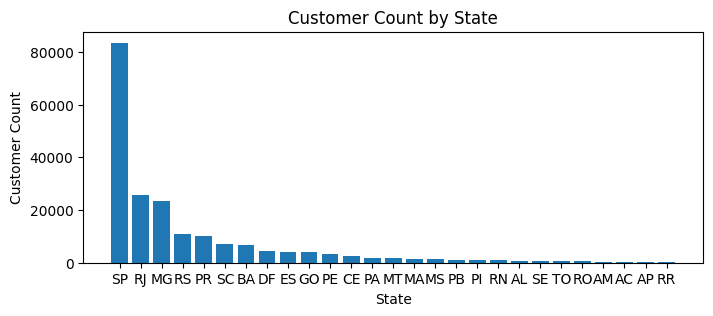

In [7]:
query = """select customer_state as state,count(customer_id) as customerCount from customers group by customer_state order by customerCount desc"""
cur.execute(query)
result = cur.fetchall()
df = pd.DataFrame(result, columns=['state', 'customerCount'])
plt.figure(figsize=(8, 3))
plt.bar(df['state'], df['customerCount'])
plt.xlabel('State')
plt.ylabel('Customer Count')
plt.title('Customer Count by State')
plt.show()

# The number of orders per month in 2018

       month  orderCount
0      April       13878
1     August       13024
2   February       13456
3    January       14538
4       July       12584
5       June       12334
6      March       14422
7        May       13746
8    October           8
9  September          32


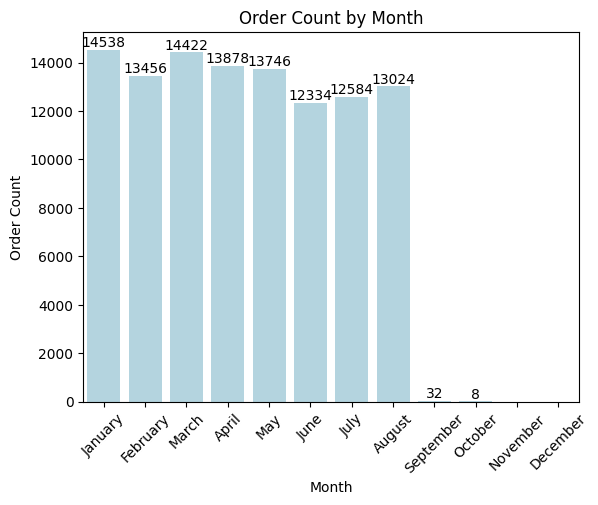

In [8]:
query = """select monthname(order_purchase_timestamp) as month,count(order_id) as orderCount from orders where year(order_purchase_timestamp)= 2018 group by month order by month """
cur.execute(query)
result = cur.fetchall()
df = pd.DataFrame(result, columns=['month', 'orderCount'])
print(df)
o=['January','February','March','April','May','June','July','August','September','October','November','December'];
ax=sns.barplot(x='month', y='orderCount', data=df, order=o,color='lightblue')
plt.xlabel('Month')
plt.ylabel('Order Count')
plt.title('Order Count by Month')
plt.xticks(rotation=45)
plt.figsize=(20, 10)
ax.bar_label(ax.containers[0])
plt.show()

# The average number of products per order, grouped by customer city

In [9]:
query="""with count_per_order as 
(
select orders.order_id as oi, orders.customer_id as ci,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by oi, ci
)
select Upper(customers.customer_city),round(avg(count_per_order.oc),1) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.ci
group by customers.customer_city
order by average_orders desc;"""
cur.execute(query)
result=cur.fetchall()
df=pd.DataFrame(result,columns=['city','average_orders'])
print(df)


                city average_orders
0     PADRE CARVALHO           14.0
1        CELSO RAMOS           13.0
2              DATAS           12.0
3      CANDIDO GODOI           12.0
4     MATIAS OLIMPIO           10.0
...              ...            ...
4105          TUIUTI            2.0
4106    TIBAU DO SUL            2.0
4107      SAO MAMEDE            2.0
4108        SAMBAIBA            2.0
4109      JAPARATUBA            2.0

[4110 rows x 2 columns]


# The percentage of total revenue contributed by each product category.

In [10]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
print(df)

                       Category  percentage distribution
0                BED TABLE BATH                    10.70
1                 HEALTH BEAUTY                    10.35
2          COMPUTER ACCESSORIES                     9.90
3          FURNITURE DECORATION                     8.93
4               WATCHES PRESENT                     8.93
..                          ...                      ...
69              HOUSE COMFORT 2                     0.01
70               CDS MUSIC DVDS                     0.01
71                     PC GAMER                     0.01
72  FASHION CHILDREN'S CLOTHING                     0.00
73       INSURANCE AND SERVICES                     0.00

[74 rows x 2 columns]


# The correlation between product price and the number of times a product has been purchased.

In [11]:
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][-1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


# The total revenue generated by each seller, and rank them by revenue.

Top 15 sellers by revenue
                           seller_id        revenue  rank
0   7c67e1448b00f6e969d365cea6b010ab  507166.907302     1
1   1025f0e2d44d7041d6cf58b6550e0bfa  308222.039840     2
2   4a3ca9315b744ce9f8e9374361493884  301245.269765     3
3   1f50f920176fa81dab994f9023523100  290253.420128     4
4   53243585a1d6dc2643021fd1853d8905  284903.080498     5
5   da8622b14eb17ae2831f4ac5b9dab84a  272219.319315     6
6   4869f7a5dfa277a7dca6462dcf3b52b2  264166.120939     7
7   955fee9216a65b617aa5c0531780ce60  236322.300502     8
8   fa1c13f2614d7b5c4749cbc52fecda94  206513.229870     9
9   7e93a43ef30c4f03f38b393420bc753a  185134.209706    10
10  6560211a19b47992c3666cc44a7e94c0  179657.749048    11
11  7a67c85e85bb2ce8582c35f2203ad736  169030.800026    12
12  25c5c91f63607446a97b143d2d535d31  160534.739773    13
13  a1043bafd471dff536d0c462352beb48  154356.910189    14
14  46dc3b2cc0980fb8ec44634e21d2718e  148864.340071    15


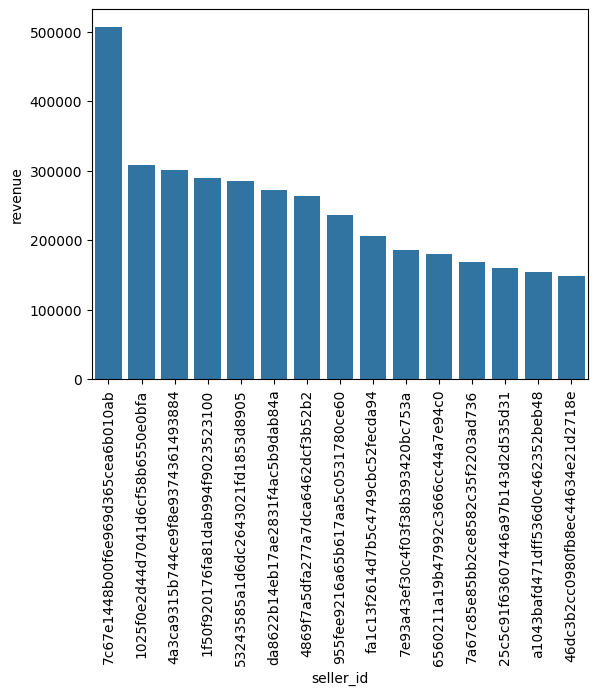

In [12]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head(15)
print("Top 15 sellers by revenue")
print(df)
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# The moving average of order values for each customer over their order history.

In [13]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment", "moving_average"])
print(df)

                             customer_id order_purchase_timestamp  payment  \
0       00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
1       00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
2       000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.41   
3       000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.41   
4       0001fd6190edaaf884bcaf3d49edf079      2017-02-28 11:06:43   195.42   
...                                  ...                      ...      ...   
207767  ffff42319e9b2d713724ae527742af25      2018-06-13 16:57:05   214.13   
207768  ffffa3172527f765de70084a7e53aae8      2017-09-02 11:53:32    45.50   
207769  ffffa3172527f765de70084a7e53aae8      2017-09-02 11:53:32    45.50   
207770  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   
207771  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   

        moving_average  
0           114.739998  
1           1

#  The cumulative sales per month for each year.

    years  months     payment  cumulative_sales
0    2016       9      504.48            504.48
1    2016      10   118180.96         118685.44
2    2016      12       39.24         118724.68
3    2017       1   276976.08         395700.76
4    2017       2   583816.02         979516.78
5    2017       3   899727.20        1879243.98
6    2017       4   835576.06        2714820.04
7    2017       5  1185837.64        3900657.68
8    2017       6  1022552.76        4923210.44
9    2017       7  1184765.84        6107976.28
10   2017       8  1348792.64        7456768.92
11   2017       9  1455524.90        8912293.82
12   2017      10  1559355.76       10471649.58
13   2017      11  2389765.60       12861415.18
14   2017      12  1756802.96       14618218.14
15   2018       1  2230008.36       16848226.50
16   2018       2  1984926.68       18833153.18
17   2018       3  2319304.24       21152457.42
18   2018       4  2321570.96       23474028.38
19   2018       5  2307964.30       2578

<Axes: xlabel='months', ylabel='cumulative_sales'>

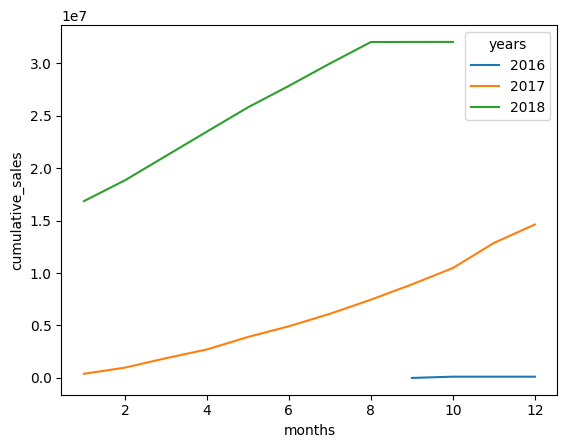

In [14]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "months", "payment", "cumulative_sales"])
print(df)
sns.lineplot(x = "months", y = "cumulative_sales", data = df, hue = "years",palette="tab10")

# The year-over-year growth rate of total sales.

   years  yoy % growth
0   2016           NaN
1   2017  12112.703761
2   2018     20.000924


<Axes: xlabel='years', ylabel='yoy % growth'>

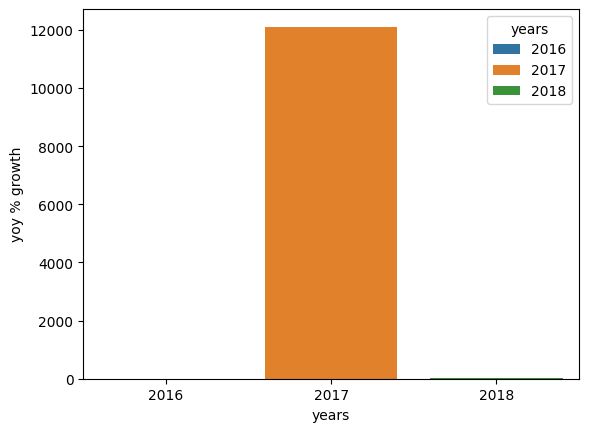

In [15]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
print(df)
sns.barplot(x = "years", y = "yoy % growth", data = df,hue="years",palette="tab10")

# The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [16]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()
if(data[0][0] == None):
    print("0% of customers made a second purchase within 6 months")
else:print(data[0][0],"% of customers made a second purchase within 6 months")

0% of customers made a second purchase within 6 months


# The top 3 customers who spent the most money in each year.

   purchaseYear                       customer_id   payment  customer_rank
0          2016  a9dc96b027d1252bbac0a9b72d837fc6   2847.10              1
1          2016  1d34ed25963d5aae4cf3d7f3a4cda173   2801.48              2
2          2016  4a06381959b6670756de02e07b83815f   2455.56              3
3          2017  1617b1357756262bfa56ab541c47bc16  27328.16              1
4          2017  c6e2731c5b391845f6800c97401a43a9  13858.62              2
5          2017  3fd6777bbce08a352fddd04e4a7cc8f6  13453.32              3
6          2018  ec5b2ba62e574342386871631fafd3fc  14549.76              1
7          2018  f48d464a0baaea338cb25f816991ab1f  13844.42              2
8          2018  e0a2412720e9ea4f26c1ac985f6a7358   9618.88              3


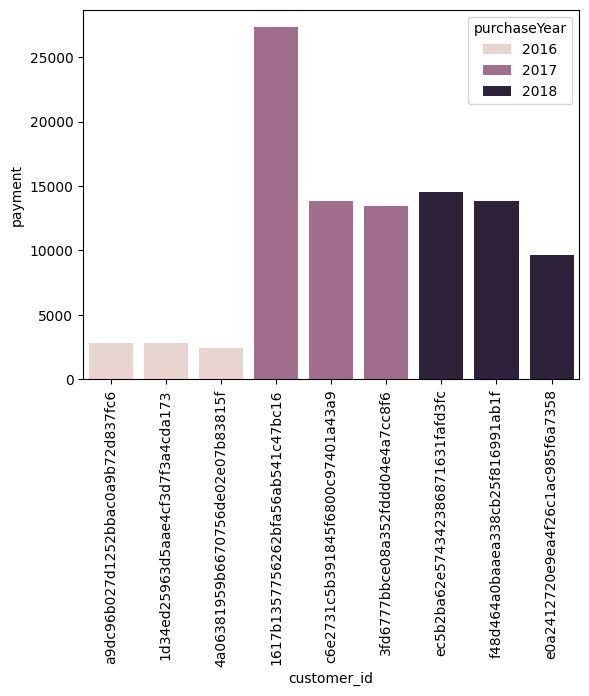

In [27]:
query = """select purchaseYear,customer_id,payment,customer_rank from
(select orders.order_id,
orders.customer_id,
year(orders.order_purchase_timestamp) as purchaseYear,
round(sum(payments.payment_value),2) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as customer_rank
from orders join payments
on payments.order_id = orders.order_id
group by orders.order_id,
orders.customer_id,
purchaseYear) as a
where customer_rank<=3
;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["purchaseYear", "customer_id","payment","customer_rank"])
print(df)
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "purchaseYear")
plt.xticks(rotation = 90)
plt.show()